# Optimization notebook
This notebook is to showcase how the multi-objective optimization procedure can be conducted with the Nile model. For that purpose, the open source Python library of Exploratory Modelling and Analysis (EMA) [Workbench](https://emaworkbench.readthedocs.io/en/latest/) will be utilised ([Kwakkel, 2017](https://www.sciencedirect.com/science/article/pii/S1364815217301251)). To fasten the process of extensive experimentation, multiprocessing and parallelization capabilities will be enabled. Although this notebook includes all the necessary steps to conduct the analysis, users are advised to run their experiment configurations .py scripts.

In [1]:
import pandas as pd
import numpy as np
import os

from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model)
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, IpyparallelEvaluator, ema_logging
from ema_workbench.em_framework.ema_ipyparallel import (start_logwatcher, set_engine_logger,
                                  initialize_engines, cleanup, _run_experiment)

os.chdir('../Model')
from model_nile import ModelNile

## Platypus (NSGAII)

In [3]:
problem = Problem(model.overarching_policy.get_total_parameter_count(), 3)
problem.types[:] = Real(0, 1)
problem.function = model.evaluate

algorithm = NSGAII(problem=problem, population_size=20)
algorithm.run(1000)

In [12]:
list(algorithm.result[-1].objectives)

[2275030.0694727204, 131.6229258485269, 32.3486392309952]

In [15]:
objectives_outcome = dict()
for i, column_name in enumerate(['Environment','Irrigation','Hydropower']):
    objectives_outcome[column_name] = [s.objectives[i] for s in algorithm.result]

objectives_df = pd.DataFrame(objectives_outcome)


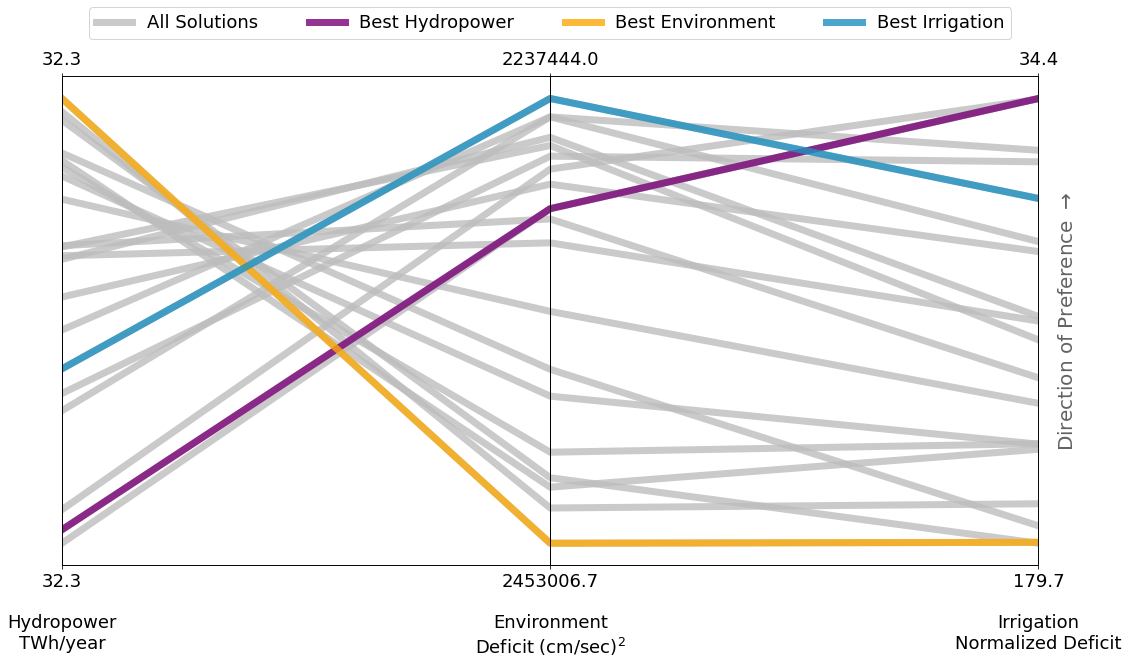

In [16]:
from various_plots import parallel_plots
parallel_plots(objectives_df)

## EMA Workbench

In [2]:
model = ModelZambezi()

In [3]:
def model_wrapper(**kwargs):
    input = [kwargs['v' + str(i)] for i in range(len(kwargs))]
    Hydropower, Environment, Irrigation = tuple(model.evaluate(np.array(input)))
    return Hydropower, Environment, Irrigation


In [4]:
from ema_workbench import (RealParameter, ScalarOutcome, Constant,
                           Model)

em_model = Model('zambeziproblem', function=model_wrapper)

em_model.levers = [RealParameter('v' + str(i), -1, 1) for i in range(model.overarching_policy.get_total_parameter_count())]

#specify outcomes
em_model.outcomes = [ScalarOutcome('Hydropower', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Environment', ScalarOutcome.MINIMIZE),
                  ScalarOutcome('Irrigation', ScalarOutcome.MINIMIZE)]

em_model.constants = [Constant("model", model)]

In [5]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, IpyparallelEvaluator, ema_logging
from ema_workbench.em_framework.ema_ipyparallel import (start_logwatcher, set_engine_logger,
                                  initialize_engines, cleanup, _run_experiment)

ema_logging.log_to_stderr(ema_logging.INFO)

with SequentialEvaluator(em_model) as evaluator:
    results = evaluator.optimize(nfe=100, searchover='levers',
    epsilons=[0.1,]*len(em_model.outcomes))

[MainProcess/INFO] generation 0: 0/100 nfe
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ema_workbench/em_framework/callbacks.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = pd.Series(dtype=dtype)
[MainProcess/INFO] optimization completed, found 6 solutions


In [5]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, IpyparallelEvaluator, ema_logging
from ema_workbench.em_framework.ema_ipyparallel import (start_logwatcher, set_engine_logger,
                                  initialize_engines, cleanup, _run_experiment)

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(em_model) as evaluator:
    results = evaluator.optimize(nfe=100000, searchover='levers',
    epsilons=[0.1,]*len(em_model.outcomes))

[MainProcess/INFO] pool started
[MainProcess/INFO] generation 0: 0/100 nfe
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/ema_workbench/em_framework/callbacks.py:192: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[name] = pd.Series(dtype=dtype)
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
ModuleNotFoundError: No module named 'model_zambezi'
Traceback (most recent call last

KeyboardInterrupt: 

In [6]:
results

,v0,v1,v2,v3,v4,v5,v6,v7,v8,v9,...,v207,v208,v209,v210,v211,v212,v213,Hydropower,Environment,Irrigation
0,0.779588,0.201705,0.060112,0.636767,0.798581,0.345376,0.653646,-0.620548,-0.662598,-0.217409,...,-0.753119,-0.570332,0.386940,0.723308,0.219570,0.557811,0.441370,2.493837e+06,186.850875,32.348664
1,0.040192,0.347205,0.993078,0.728187,-0.821870,-0.729164,-0.899818,-0.724506,-0.920092,0.252502,...,0.279363,0.186763,0.997651,-0.769177,0.803538,-0.005113,0.040481,2.896740e+06,118.501862,32.348680
2,-0.285869,-0.655546,0.100250,0.311876,0.959539,0.739565,-0.101628,0.573919,-0.678649,0.435777,...,0.686692,-0.341391,-0.696906,-0.452273,-0.033438,-0.096995,-0.893748,2.669807e+06,131.747986,32.348666
3,0.370236,-0.442871,0.229799,-0.915788,0.950993,0.091696,0.605993,0.855763,-0.305694,0.776351,...,-0.433078,-0.266858,0.193569,0.978078,-0.106756,-0.676707,0.417583,2.365792e+06,5631.832971,32.348668
4,-0.928966,0.555090,0.637855,0.019357,0.553940,0.539216,-0.868695,-0.664162,0.754990,-0.663415,...,0.594178,0.641273,0.994029,-0.006891,-0.841706,0.898323,-0.482677,2.945953e+06,22.554832,32.348672
5,0.551018,-0.807415,0.472843,0.784722,0.916855,0.752038,0.337296,0.318805,0.049758,0.458928,...,0.432575,-0.891807,-0.429767,-0.110324,-0.667248,0.147203,0.486275,2.652515e+06,168.650471,32.348670
